In [1]:
import tone
import utils
from utils import *

tone.utils.ipython.autoreload(utils)
tone.utils.learning.ignore_warning()
device = tone.utils.learning.try_use_device()
device

device(type='cuda')

In [2]:
lags = 12
batch_size = 256
epoch = 50

dataloader = torch.utils.data.DataLoader(
    dataset=utils.TrafficDataset(lags),
    batch_size=batch_size,
    drop_last=True,
    generator=torch.Generator(device=device),
    shuffle=False,
)
batch = len(dataloader)

model = utils.LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters())

progress = []

with tqdm(total=epoch * batch) as bar:
    for e in range(epoch):
        for i, (x, t) in enumerate(dataloader):
            bar.set_description(f"({e + 1:02}/{epoch}) | ({i + 1:02}/{batch})")
            y = model.forward(x)
            loss = criterion(y, t.reshape(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress.append(loss.item())
            bar.update()
            bar.set_postfix(loss=f"{loss.item():0.6}")


(50/50) | (30/30): 100%|██████████| 1500/1500 [00:07<00:00, 191.70it/s, loss=0.00285652]


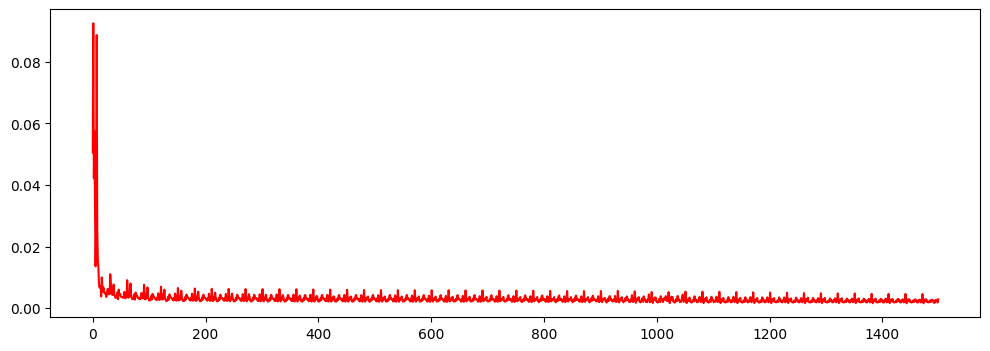

In [3]:
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(progress, 'r')
plt.show()
plt.close()

In [4]:
tone.utils.learning.save_module(model, 'models/lstm.pt')

In [5]:
pts = glob.glob("models/*.pt")
models = {}
for pt in pts:
    model = tone.utils.learning.load_module(pt)
    name = type(model).__name__
    models[name] = model

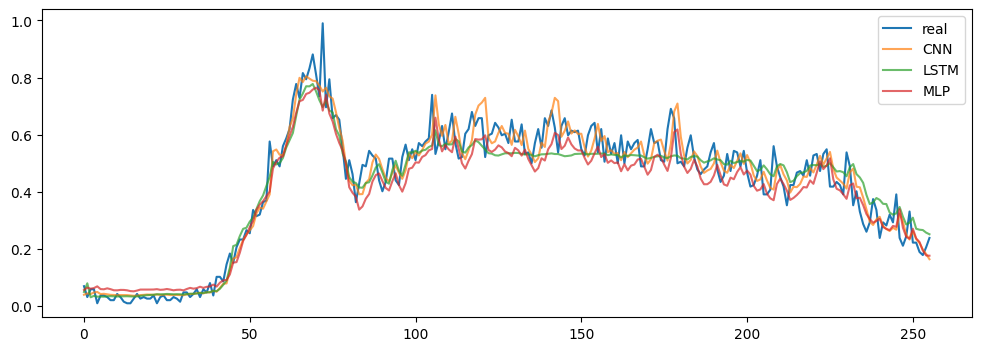

In [6]:
dataloader = torch.utils.data.DataLoader(
    dataset=utils.TrafficDataset(lags, train=False, len=500),
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    generator=torch.Generator(device=device),
)

real = []
for model in models.values():
    model.pred = []

for x, t in dataloader:
    real.append(t)
    for model in models.values():
        y = model.forward(x)
        model.pred.append(y)


real = torch.cat(real).detach().cpu()
for model in models.values():
    model.pred = torch.cat(model.pred).detach().cpu()

fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(real, label='real')
for model in models.values():
    ax.plot(model.pred, alpha=0.7, label=type(model).__name__)

plt.legend()
plt.show()
plt.close()

In [7]:
df = pd.DataFrame()

for name, model in models.items():
    m = tone.utils.learning.metrics(real, model.pred)
    df['metric'] = m.keys()
    df[name] = m.values()

df

,metric,CNN,LSTM,MLP
0,mape,0.203432,0.205231,0.300242
1,mse,0.003769,0.003997,0.004917
2,rmse,0.061392,0.063224,0.070123
3,mae,0.046495,0.049127,0.054012
4,vs,0.921185,0.919130,0.917188
5,r2,0.921108,0.916327,0.897072
